In [73]:
!rm -r /kaggle/working/*
%cd /kaggle/working

/bin/bash: line 1: /usr/bin/rm: Argument list too long


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/kaggle/working


In [74]:
import os
import sys

PACKAGE_DIR = "/kaggle/src"
sys.path.append(PACKAGE_DIR)
sys.path.append(os.path.join(PACKAGE_DIR, "Penguin-ML-Library"))

In [75]:
from pprint import pprint

import yaml
from penguinml.utils.logger import get_logger, init_logger
from penguinml.utils.set_seed import seed_base

MODEL_NAME = "ensemble"
CFG = yaml.safe_load(open(os.path.join(PACKAGE_DIR, "config.yaml"), "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])
CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

init_logger(f"{ CFG[MODEL_NAME]['execution']['exp_id']}.log")
logger = get_logger("main")
seed_base(CFG[MODEL_NAME]["execution"]["seed"])

pprint(CFG)

ensemble_001


set seed: 46


{'cnn': {'execution': {'best_exp_id': 'exp_024',
                       'exp_id': 'exp_024',
                       'seed': 46},
         'optimizer': {'lr': 0.01},
         'trainer': {'device': 'cuda',
                     'direction': 'minimize',
                     'es_patience': 20,
                     'loss_window': 100000,
                     'max_epoch': 15,
                     'monitor': 'valid_MeanAbsoluteError'}},
 'dataset': {'competition_dir': '/kaggle/input/atmaCup#18_dataset',
             'train_fold_path': '/kaggle/input/cv-split/train_folds.csv'},
 'deberta': {'execution': {'best_exp_id': 'exp_018',
                           'exp_id': 'exp_018',
                           'seed': 46}},
 'ensemble': {'execution': {'best_exp_id': 'ensemble_001',
                            'exp_id': 'ensemble_001',
                            'seed': 46},
              'weights': {'cnn': 0.5, 'xgboost': 0.5}},
 'lightgbm': {'execution': {'best_exp_id': 'exp_023',
                  

In [76]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from const import TARGET_COLS


In [77]:
train = pl.read_csv(os.path.join(CFG["dataset"]["competition_dir"], "train_features.csv")).sort("ID")

In [78]:
weights = [0.2, 0.6, 0.2]
# weights = [0, 1, 0]

In [79]:
oof_xgb = pl.read_csv(os.path.join("/kaggle/output", CFG["lightgbm"]["execution"]["best_exp_id"], "oof.csv")).sort(
    "ID"
)
oof_cnn = pl.read_csv("/kaggle/output/exp_024/oof.csv").sort("ID")
oof_cnn2 = pl.read_csv("/kaggle/output/exp_014/oof.csv").sort("ID")

oof = oof_xgb.clone()
oof = oof.with_columns(
    [oof_xgb[c] * weights[0] + oof_cnn[c] * weights[1] + oof_cnn2[c] * weights[2] for c in TARGET_COLS]
)
oof.write_csv(os.path.join(CFG["output_dir"], "oof.csv"))

In [80]:
sub_xgb = pl.read_csv(
    os.path.join("/kaggle/output", CFG["lightgbm"]["execution"]["best_exp_id"], "submission.csv")
).sort("ID")
sub_cnn = pl.read_csv("/kaggle/output/exp_024/submission.csv").sort("ID")
sub_cnn2 = pl.read_csv("/kaggle/output/exp_014/submission.csv").sort("ID")

sub = sub_xgb.clone()
sub = sub.with_columns(
    [sub_xgb[c] * weights[0] + sub_cnn[c] * weights[1] + sub_cnn2[c] * weights[2] for c in TARGET_COLS]
)
sub.to_pandas()[TARGET_COLS].to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

In [81]:
mae = np.mean(np.abs(train[TARGET_COLS].to_numpy() - oof[[c for c in TARGET_COLS]].to_numpy()))
mae

0.18684028342301254

In [82]:
test = pl.read_csv(os.path.join(CFG["dataset"]["competition_dir"], "test_features.csv"))
assert (test["ID"] == sub["ID"]).all()

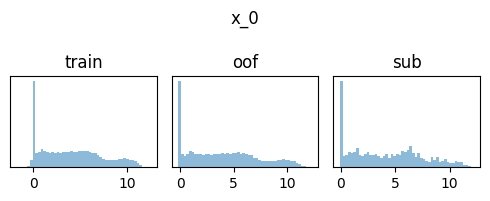

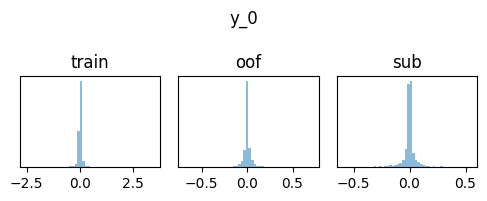

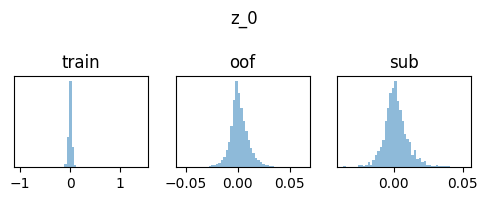

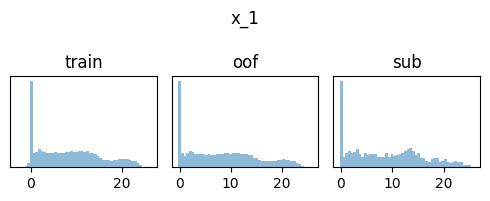

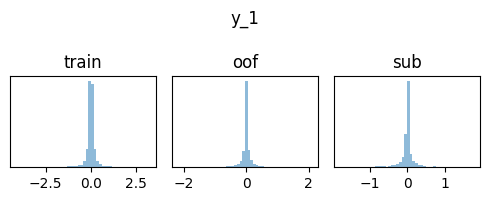

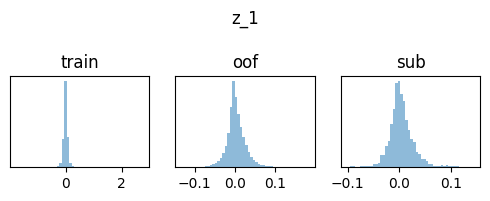

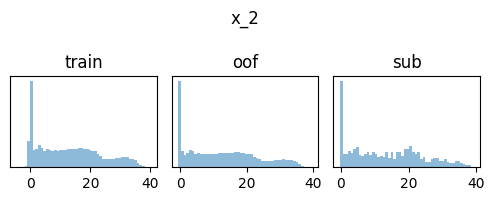

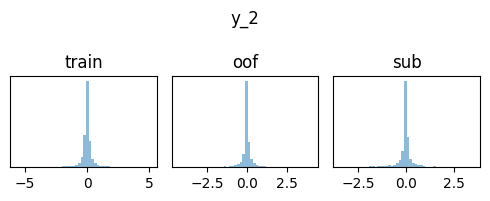

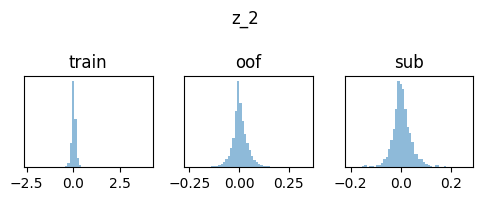

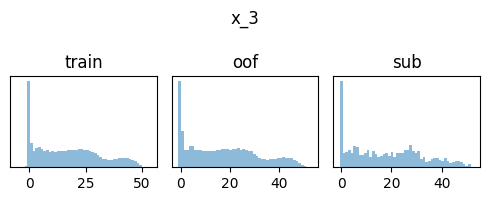

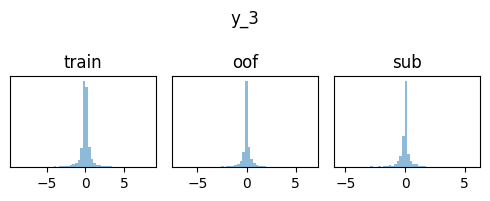

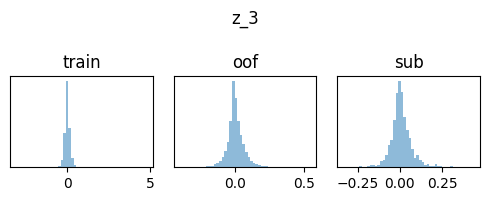

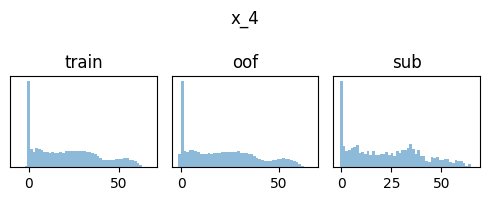

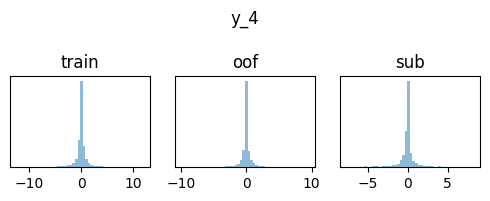

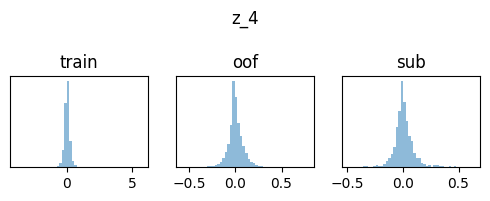

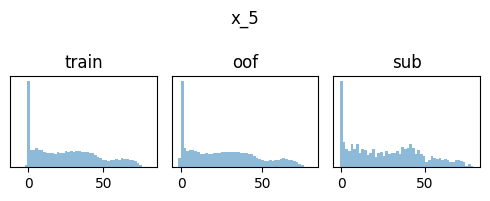

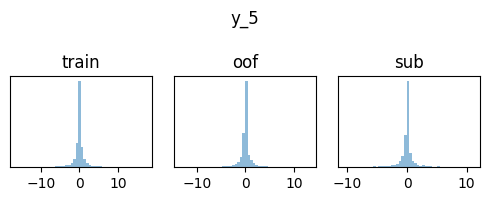

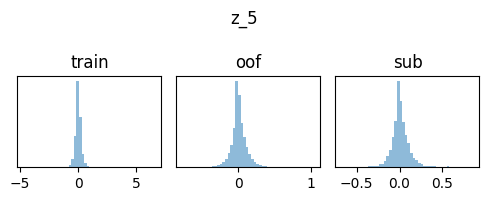

In [83]:
for c in TARGET_COLS:
    fig, axs = plt.subplots(1, 3, figsize=(5, 2))
    axs[0].hist(train[c], bins=50, alpha=0.5, label="train", density=True)
    axs[0].set_title("train")
    axs[0].yaxis.set_visible(False)
    axs[1].hist(oof[c], bins=50, alpha=0.5, label="oof", density=True)
    axs[1].yaxis.set_visible(False)
    axs[1].set_title("oof")
    axs[2].hist(sub[c], bins=50, alpha=0.5, label="sub", density=True)
    axs[2].yaxis.set_visible(False)
    axs[2].set_title("sub")
    plt.suptitle(c)
    plt.tight_layout()
    plt.show()

In [84]:
train.filter(pl.col("z_5").abs() > 2).sort(pl.col("z_5").abs())["ID"][-6]

'01eff8e225162bfce00d0b22c093e1e5_20'